$버전 2.0 출시$
----
# <font color='yellow'>__구글 이미지 대량 다운로드__</font>
----

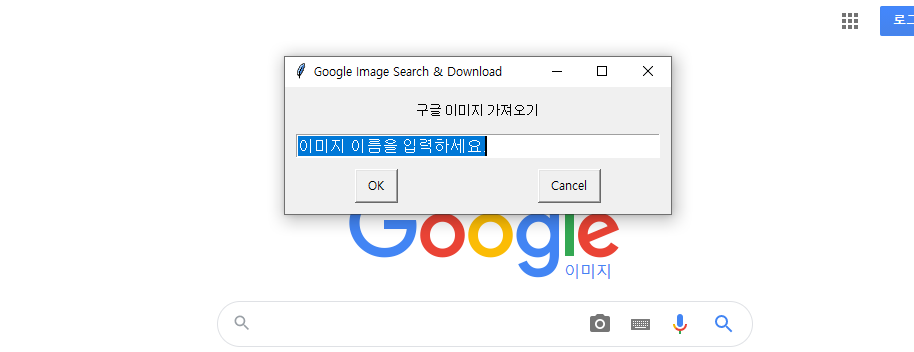

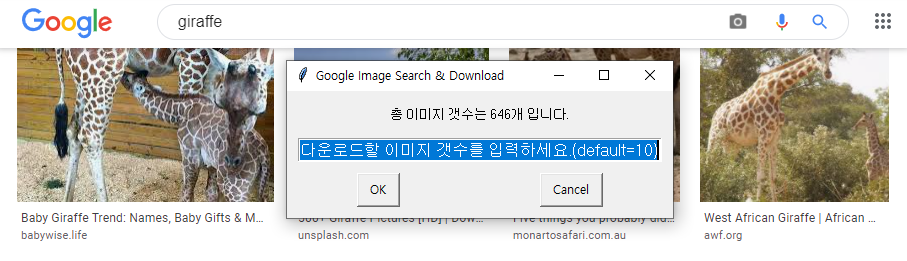

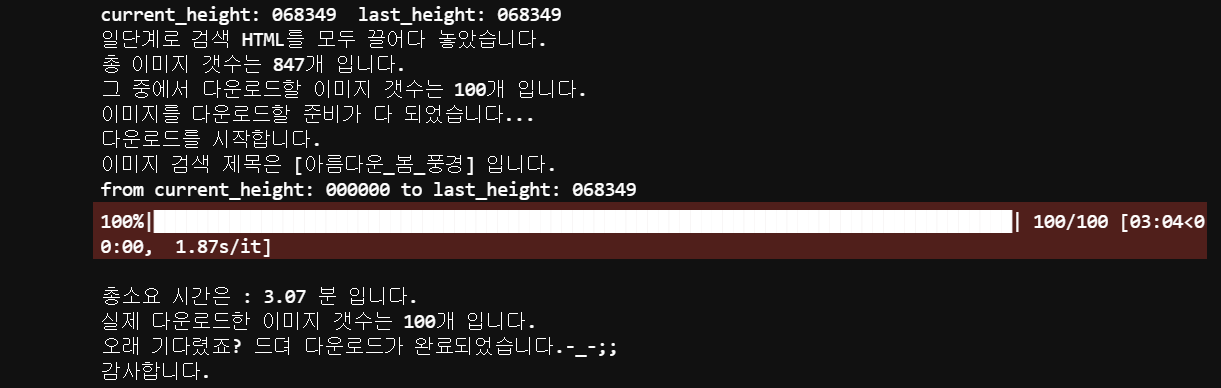

In [1]:
#%%writefile google_image_search_and_download.py
################################################################################################
# Python coder : sjkim (kim.sajoong@gmail.com)
# last update  : 2021-Feb-5
# descrption   : version 2.2.1 (version 2 was changed completely)
# How to download hundreds of Google images within few minutes(about 20 minutes), 
# using a few lines of codes(about 100 lines) in Python.
# the access time for downloading was setting by a random uniform to avoid Google's surveillance. 
################################################################################################
#----------------------------------------------------------------------------------------------#
# step 0. Imports Python Packages
#----------------------------------------------------------------------------------------------#
# python==3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
#
# bs4==4.8.2
# selenium==3.141.0
# urllib.request==3.8
# pyautogui==0.9.52
#----------------------------------------------------------------------------------------------#
from tqdm.notebook import tqdm, trange
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from urllib.request import urlretrieve
import urllib.request
import time, random, os, sys 
import pyautogui
################################################################################################
#######################          The maim code is as folowings          ########################
################################################################################################
#----------------------------------------------------------------------------------------------#
# step 1. Open up a Chrome web driver and go to the Google Image search page in Korean
#----------------------------------------------------------------------------------------------#
chrome_driver_path = "D:\\Data_Engineering_Practice\\web scraping\\chromedriver.exe"
driver = webdriver.Chrome(chrome_driver_path)
driver.get('https://www.google.co.kr/imghp?hl=ko')
driver.implicitly_wait(20)
#----------------------------------------------------------------------------------------------#
# step 2. Pop up a dialog box for getting the name of a search image 
#----------------------------------------------------------------------------------------------#
# 한글이 안되면 shift+space를 누르고 나서 한/영 토글 
try:  
    search_image_name = pyautogui.prompt(title='Google Image Search & Download',
                                         text='구글 이미지 가져오기', 
                                         default='이미지 이름을 입력하세요.')
    print(f"이미지 검색 이름 : [{search_image_name}]")
    if search_image_name == None or search_image_name == "이미지 이름을 입력하세요.":
        raise Exception("[이미지 검색어 오류]")
        
except Exception as e:
    print(e, "검색할 이미지가 없습니다.")
    driver.close()
    sys.exit()
#----------------------------------------------------------------------------------------------#
# step 3. Type the search image name automatically
#----------------------------------------------------------------------------------------------#
search_input = driver.find_element_by_xpath('//*[@id="sbtc"]/div/div[2]/input') # 검색어 입력
search_input.send_keys(search_image_name)
search_input.send_keys(Keys.ENTER)
time.sleep(random.uniform(2,3))

if len(search_image_name.split()) > 1:  # 아름다운 배경화면 >>> 아름다운_배경화면 으로 수정하기 
    search_image_dir = search_image_name.split()
    search_image_dir = "_".join(search_image_dir)
else:
    pass
#----------------------------------------------------------------------------------------------#
# step 4. Get the last height info for scrolling down
#----------------------------------------------------------------------------------------------#
last_height = driver.execute_script('return document.body.scrollHeight') # 현재 마지막 값 가져오기
#----------------------------------------------------------------------------------------------#
# step 5. Keep scrolling down the webpage until it cannot scroll no more
#----------------------------------------------------------------------------------------------#
current_height = 0
no_more_message = '//*[@id="islmp"]/div/div/div/div/div[4]/div[2]/div[1]/div'

while driver.find_element_by_tag_name('html'):
    
    last_height = driver.execute_script('return document.body.scrollHeight')
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    #current_height = driver.execute_script("return window.pageYOffset")
    time.sleep(random.uniform(1,2))
    
    print(f"\rcurrent_height: {current_height:06d}  last_height: {last_height:06d}", end="")

    if current_height == last_height:
        path = '//*[@id="islmp"]/div/div/div/div/div[5]/input' # 결과 더 보기 버튼 위치
        more_button_image = driver.find_element_by_xpath(path)
        
        if more_button_image.is_displayed() and more_button_image.is_enabled():
            more_button_image.click()                          # 결과 더 보기 버튼 클릭
        
        message = driver.find_element_by_xpath(no_more_message)
        if message.text == "더 이상 표시할 콘텐츠가 없습니다.":  # 마지막 페이지 확인하기
            break
            
    else:
        current_height = last_height                           # 페이지 높이값 갱신하기
        continue
    
print("\n일단계로 검색 HTML를 모두 끌어다 놓았습니다.")
#----------------------------------------------------------------------------------------------#
# step 6.Make a download dir if not exists.
#----------------------------------------------------------------------------------------------#
DATASET = "dataset"
if not os.path.isdir(DATASET):
    os.mkdir(DATASET)
else:
    pass

download_dir = os.path.join(DATASET, search_image_dir) 
if not os.path.isdir(download_dir):
    os.mkdir(download_dir)                             # 현재 폴더에서 하위 폴더를 만들기
else:
    pass
#----------------------------------------------------------------------------------------------#
# step 7. Find all the image class(구글의 홈피가 개편되면 class name을 확인할 것)
#----------------------------------------------------------------------------------------------#
html     = driver.page_source                          # 전체 HTML 소스 가져오기
soup     = BeautifulSoup(html, "html.parser")          # 맛있는 스프로 조리하기
images   = soup.find_all("img", class_="rg_i Q4LuWd")  # real image만 가져오기
#----------------------------------------------------------------------------------------------#
# step 8. Pop up a dialog box for getiing the number of download images
#----------------------------------------------------------------------------------------------#
try:
    number = pyautogui.prompt(title   = 'Google Image Search & Download',  
                              text    = f"총 이미지 갯수는 {len(images):,}개 입니다.",
                              default = "다운로드할 이미지 갯수를 입력하세요.(default=10)")
    number = int(number)   
except Exception as e:
    number = 10           # 디폴트 값을 10으로 설정
    
if number > len(images):  # 오바 입력하면 최대값으로 설정
    number = len(images)
    
print(f"총 이미지 갯수는 {len(images):,}개 입니다.")
print(f"그 중에서 다운로드할 이미지 갯수는 {number}개 입니다.")
#----------------------------------------------------------------------------------------------#
# step 9. Init vars and move the scroll bar to the top of the screen 
#----------------------------------------------------------------------------------------------#
real_download_number = 0

print("이미지를 다운로드할 준비가 다 되었습니다...")
time.sleep(random.uniform(1,2))                                           # 잠시 대기 중요
driver.execute_script('window.scrollTo(document.body.scrollHeight, 0);')  # 최상단으로 UP 이동
time.sleep(random.uniform(2,3))                                           # 급체를 막으려면
start = time.time()                                                       # 시작시간 설정
print("다운로드를 시작합니다.")
print(f"이미지 검색 제목은 [{search_image_name}] 입니다.")
#----------------------------------------------------------------------------------------------#
# step 10. confirm whether the current height is the top of the screen
#----------------------------------------------------------------------------------------------#
current_height = driver.execute_script("return window.pageYOffset")       # 눈으로 한번 더 보자
print(f"from current_height: {current_height:06d} to last_height: {last_height:06d}")
#----------------------------------------------------------------------------------------------#
# step 11. get the image source and save the image in a png format as you want
#----------------------------------------------------------------------------------------------#   
for i in trange(number, desc="진행 모너터링"):
    time.sleep(random.uniform(1,2))
    
    try: # getting url using src or data-src attribute in bs4.element.Tag
        content = images[i]['src']
    except KeyError as e:
        content = images[i]['data-src']
        
    try:
        # Adding information about user agent for preventing HTTP Error 403
        opener=urllib.request.build_opener()
        opener.addheaders=[('User-Agent',
                            'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 \
                            (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
        
        urllib.request.install_opener(opener)
        # setting a file name and image URL
        file_name = f'.\\{download_dir}\\{search_image_dir}_{i:03d}.png'
        
        # calling urlretrieve function to get resource
        result = urlretrieve(content, file_name)       # 이미지를 가져와 내 폴더에 파일 저장하기
        #print(f"{i:03d}: {result[0]}")                 # 결과 보기(이거이 중요, 실패하면 오류)
        real_download_number += 1                      # 실제 다운로드 갯수 증가하기
    except Exception as e:
        print(i, e)
#----------------------------------------------------------------------------------------------#
# step 12. Close the driver
#----------------------------------------------------------------------------------------------#
driver.close()
#----------------------------------------------------------------------------------------------#
# step 13. show the total elapsed time and the number of download image files
#----------------------------------------------------------------------------------------------#
elapse_time = time.time() - start                      # 경과 시간 계산하기

if elapse_time >= 60.0:
    elaspe_time = round(elapse_time / 60, 2)
    print(f"\n총소요 시간은 : {elaspe_time} 분 입니다.")
else:
    elaspe_time = round(elapse_time, 2)
    print(f"\n총소요 시간은 : {elaspe_time} 초 입니다.")
    
print(f"실제 다운로드한 이미지 갯수는 {real_download_number}개 입니다.")
print("오래 기다렸죠? 드뎌 다운로드가 완료되었습니다.-_-;;")
print("감사합니다.")
#----------------------------------------------------------------------------------------------#
# Life is too short, so we need Python...
################################################################################################

이미지 검색 이름 : [우주 소행성]
current_height: 047285  last_height: 047285
일단계로 검색 HTML를 모두 끌어다 놓았습니다.
총 이미지 갯수는 645개 입니다.
그 중에서 다운로드할 이미지 갯수는 10개 입니다.
이미지를 다운로드할 준비가 다 되었습니다...
다운로드를 시작합니다.
이미지 검색 제목은 [우주 소행성] 입니다.
from current_height: 000000 to last_height: 047285


진행 모너터링:   0%|          | 0/10 [00:00<?, ?it/s]


총소요 시간은 : 15.92 초 입니다.
실제 다운로드한 이미지 갯수는 10개 입니다.
오래 기다렸죠? 드뎌 다운로드가 완료되었습니다.-_-;;
감사합니다.


----
#### 다운로드한 이미지 살펴보기
----

In [2]:
%run view_download_image.py

D:\Data_Engineering_Practice\selenium
====== 이미지 살펴볼 폴더 번호를 선택하세요. =======
[001] : dataset\거친_파도
[002] : dataset\스텔스_전투기
[003] : dataset\아름다운_어촌_풍경
[004] : dataset\아름다운_에베레스트
[005] : dataset\아름다운_여름_바다_풍경
[006] : dataset\아름다운_호수_풍경
[007] : dataset\우주_소행성
[008] : dataset\우주_화성


[번호] >>>  7


당신의 선택은 7번 [dataset\우주_소행성] 폴더입니다.
['dataset\\우주_소행성\\우주_소행성_000.png',
 'dataset\\우주_소행성\\우주_소행성_001.png',
 'dataset\\우주_소행성\\우주_소행성_002.png',
 'dataset\\우주_소행성\\우주_소행성_003.png',
 'dataset\\우주_소행성\\우주_소행성_004.png',
 'dataset\\우주_소행성\\우주_소행성_005.png',
 'dataset\\우주_소행성\\우주_소행성_006.png',
 'dataset\\우주_소행성\\우주_소행성_007.png',
 'dataset\\우주_소행성\\우주_소행성_008.png',
 'dataset\\우주_소행성\\우주_소행성_009.png']
